In [1]:
import pandas as pd
import numpy as np
import os, time, gc, datetime
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

import shap
shap.initjs()

from eli5.sklearn import PermutationImportance
import eli5
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lime 
import lime.lime_tabular 
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
from skater.util.dataops import show_in_notebook
from graphviz import Source
from IPython.display import SVG
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots
from sklearn.impute import SimpleImputer
from eli5.sklearn import PermutationImportance
import lightgbm as lgb
from sklearn.model_selection import cross_val_score




Using TensorFlow backend.


In [2]:
def load_data():
    
    train_transaction = pd.read_csv("train_transaction.csv") #../data/train_transaction.csv
    train_identity = pd.read_csv("train_identity.csv")  #../data/train_identity.csv
    data=pd.merge(train_transaction,train_identity,how='left',on='TransactionID')
    
    return data

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return data

In [4]:
data = load_data()
data=reduce_mem_usage(data)

Mem. usage decreased to 650.48 Mb (66.8% reduction)


In [5]:
data = data.drop(['V'+str(i) for i in range(1,340)],axis=1)

In [6]:
#Removing all ID columns 

data = data.drop(columns = ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10',
                 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21',
                 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
                 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38'], axis = 1)

print(data.shape)

(590540, 57)


In [7]:
#Removing all Categorical columns 

data= data.drop(columns= ['ProductCD','DeviceType','DeviceInfo','TransactionID', 'P_emaildomain','R_emaildomain',   
                          'addr1', 'addr2', 'card1', 'card2', 'card3', 'card4','card5', 'card6','dist1', 'dist2', 
                    'D1', 'D2', 'D3', 'D4','D5', 'D6', 'D7', 'D8', 'D9', 'D10','D11','D12', 'D13', 'D14', 'D15', 
                        'M1','M2', 'M3','M4', 'M5',  'M6', 'M7', 'M8', 'M9'], axis = 1)

print(data.shape)

(590540, 17)


In [8]:
data.head()

,isFraud,TransactionDT,TransactionAmt,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,0,86400,68.5,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
1,0,86401,29.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,0,86469,59.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,0,86499,50.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,0,86506,50.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


In [9]:
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
data['Date'] = data['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
data['Date']

0        2017-12-02 00:00:00
1        2017-12-02 00:00:01
2        2017-12-02 00:01:09
3        2017-12-02 00:01:39
4        2017-12-02 00:01:46
                 ...        
590535   2018-06-01 23:57:27
590536   2018-06-01 23:57:29
590537   2018-06-01 23:57:59
590538   2018-06-01 23:58:08
590539   2018-06-01 23:58:51
Name: Date, Length: 590540, dtype: datetime64[ns]

In [10]:
#Label encoding

number = LabelEncoder()
for i in data.columns:
    if (data[i].dtype == 'object'):
        data[i] = number.fit_transform(data[i].astype('str'))
        data[i] = data[i].astype('object')

In [11]:

d1 = datetime.datetime(2018, 5, 1)
train_X = data[data['Date']<d1]
test_X = data[data['Date']>= d1]


y_train = train_X['isFraud'].copy()
conta = sum(y_train) / len(y_train)
X_train  = train_X.drop(columns = ['Date', 'isFraud'], axis = 1)

X_test1 = test_X.drop('Date', axis = 1)
X_test = test_X.drop(columns = ['Date', 'isFraud'], axis = 1)
y_test = X_test1['isFraud'].copy()


In [12]:
# Handling missing value
from sklearn.impute import SimpleImputer
print('Filling NaNs with mean')

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train[:] = imp_mean.fit_transform(X_train.replace(np.inf, 99999).values)

Filling NaNs with mean


In [13]:
print('Filling NaNs with mean')

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_test[:] = imp_mean.fit_transform(X_test.replace(np.inf, 99999).values)

Filling NaNs with mean


In [14]:
from sklearn.ensemble import RandomForestClassifier
from treeinterpreter import treeinterpreter as ti

rf = RandomForestClassifier().fit(X_train, y_train) 

In [15]:
prediction, bias, contrib = ti.predict(rf, X_test)

In [16]:
prediction[0]

array([1., 0.])

In [17]:
""" for j in range(len(prediction)):
    if y_test.values[j] != prediction[j][1]:
        print('features contributions for the misprediction')
        for i in range(len(train_X.columns)):
            print(train_X.columns[i],contrib[j][i][1])
        input('j='+str(j)) """ 

" for j in range(len(prediction)):\n    if y_test.values[j] != prediction[j][1]:\n        print('features contributions for the misprediction')\n        for i in range(len(train_X.columns)):\n            print(train_X.columns[i],contrib[j][i][1])\n        input('j='+str(j)) "

In [18]:
from sklearn.metrics import accuracy_score

y_pred = rf.predict(X_train)
print('Train accuracy score:',accuracy_score(y_train,y_pred))
print('Test accuracy score:', accuracy_score(y_test,rf.predict(X_test)))

Train accuracy score: 0.9971151124343272
Test accuracy score: 0.9672390102459238


#### The five most correlated variables with Fraud are TransactionAmt, C4, C8, C12, C7

### Test Set Evaluation of the Random Forest Model and Regression Coefficients

In [19]:
from sklearn.linear_model import LogisticRegression


def logistic_regression(X_train,y_train):
    logreg = LogisticRegression().fit(X_train,y_train)
    return(logreg)


In [20]:
logreg_result = logistic_regression(X_train, y_train)

In [21]:
import sklearn
y_pred=logreg_result.predict(X_test)

In [22]:
print("Training set score: {:.3f}".format(logreg_result.score(X_train,y_train)))
print("Test set score: {:.3f}".format(logreg_result.score(X_test,y_test)))

Training set score: 0.965
Test set score: 0.965


In [23]:
import statsmodels.api as sm

logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.201772
         Iterations 13
                          Results: Logit
Model:              Logit            Pseudo R-squared: -0.329     
Dependent Variable: isFraud          AIC:              201042.5143
Date:               2019-11-20 14:16 BIC:              201220.4116
No. Observations:   498113           Log-Likelihood:   -1.0051e+05
Df Model:           15               LL-Null:          -75624.    
Df Residuals:       498097           LLR p-value:      1.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     13.0000                                       
------------------------------------------------------------------
                  Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
TransactionDT    -0.0000   0.0000 -178.3419 0.0000 -0.0000 -0.0000
TransactionAmt   -0.0070   0.0001  -91.0234 0.0000 -

In [24]:
### Features Regression Coefficients (from higher to lower )

""" C4                0.2672  
    C5                0.2132   
    C9                0.1181  
    C11               0.1084     
    C6                0.0753   
    C12               0.0724   
    C10               0.0437
    C1                0.0281 
    C8                0.0075  
    TransactionAmt   -0.0070   
    C13              -0.0231   
    C2               -0.0416   
    C7               -0.1904   
    C14              -0.6508
    C3               -6.0684       """

' C4                0.2672  \n    C5                0.2132   \n    C9                0.1181  \n    C11               0.1084     \n    C6                0.0753   \n    C12               0.0724   \n    C10               0.0437\n    C1                0.0281 \n    C8                0.0075  \n    TransactionAmt   -0.0070   \n    C13              -0.0231   \n    C2               -0.0416   \n    C7               -0.1904   \n    C14              -0.6508\n    C3               -6.0684       '

In [25]:
sklearn.metrics.accuracy_score(y_test,y_pred)

0.9652374306209225

In [26]:
y_pred_prob_yes=logreg_result.predict_proba(X_test)

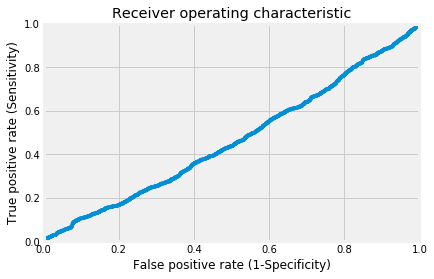

In [27]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_yes[:,1])
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Receiver operating characteristic')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)

In [28]:
#Training the XGBoost model
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


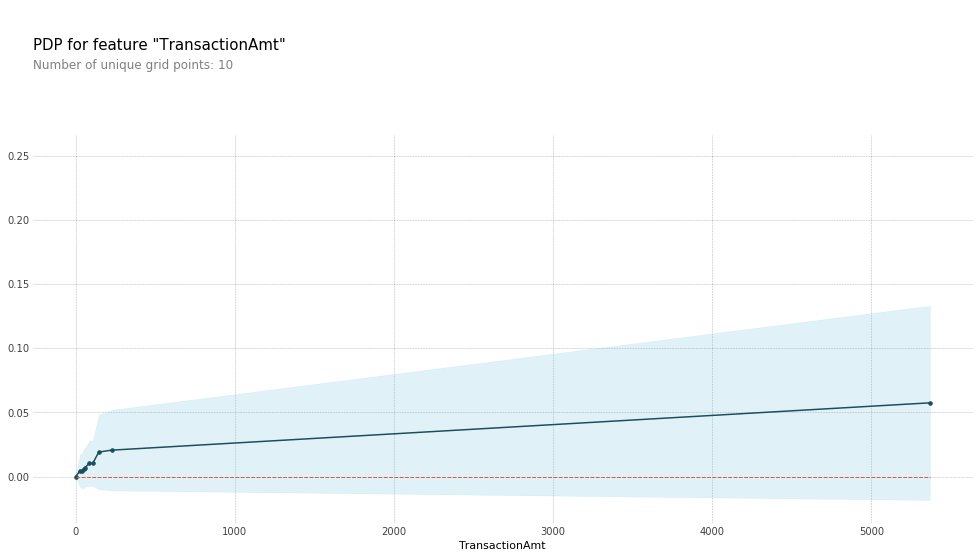

In [29]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

# Create the data and plot it
pdp_trans = pdp.pdp_isolate(model=xgb_model, dataset=X_test, model_features=list(X_test.columns), feature='TransactionAmt')
pro = pdp.pdp_plot(pdp_trans, 'TransactionAmt')
plt.show()

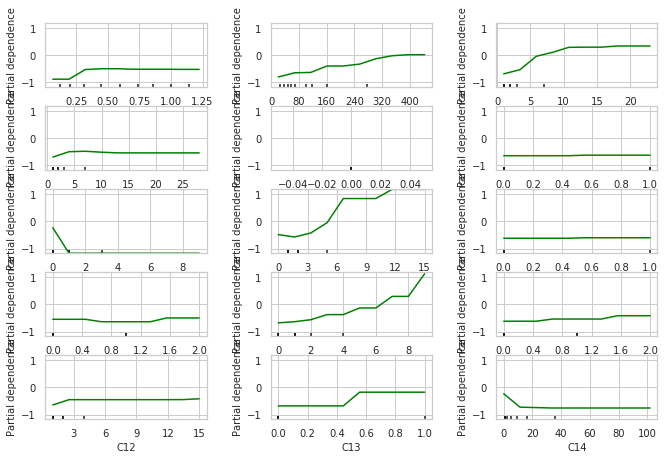

In [30]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import seaborn as sns

bg_color = (0.5, 0.5, 0.5)

sns.set(rc={"font.style":"normal",
            "axes.facecolor":bg_color,
            "axes.titlesize":20,
            "figure.facecolor":bg_color,
            "text.color":"black",
            "xtick.color":"black",
            "ytick.color":"black",
            "axes.labelcolor":"black",
            "axes.grid":False,
            'axes.labelsize':10,
            'figure.figsize':(10.0, 10.0),
            'xtick.labelsize':10,
            'ytick.labelsize':10})
sns.set_style("whitegrid")
my_model = GradientBoostingClassifier()
my_model.fit(X=X_train, y=y_train)
# Here we make the plot
my_plots = plot_partial_dependence(my_model ,       
                                   features=[0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], # column numbers of plots we want to show
                                   X=X_train, # raw predictors data.
                                   feature_names = ['TransactionAmt', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14'], # labels on graphs
                                   grid_resolution=10) # number of values to plot on x axis
plt.show()

In [31]:
from pycebox.ice import ice, ice_plot

# pcyebox likes the data to be in a DataFrame so let's create one with our imputed data
# we first need to impute the missing data
train_X_df = pd.DataFrame(X_train, columns=X_train.columns)

In [32]:
lgb_params =  {'num_leaves': 491,
         'min_child_weight': 0.03454472573214212,
         'feature_fraction': 0.3797454081646243,
         'bagging_fraction': 0.4181193142567742,
         'min_data_in_leaf': 106,
         'objective': 'binary',
         'max_depth': -1,
         'learning_rate': 0.006883242363721497,
         "boosting_type": "gbdt",
         "bagging_seed": 11,
         "metric": 'auc',
         'reg_alpha': 0.3899927210061127,
         'reg_lambda': 0.6485237330340494,
         'random_state': 47 }



In [33]:
train_data=lgb.Dataset(X_train,label=y_train,feature_name=X_train.columns.tolist())


In [34]:
import datetime 
from datetime import *
import lightgbm as lgb

num_round=50
start=datetime.now()
lgbm=lgb.train(lgb_params,train_data,num_round,feature_name=list(X_train.columns))
stop=datetime.now()


#lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt')
#Equivalent way of fitting light gbm

lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',
                        # class_weight='balanced', #used only in multiclass training
                         #is_unbalance ='True'   #used in binary class training    
                         objective='binary',
                         n_jobs=-1, 
                         verbose=0)

lgb_model = lgb_estimator.fit(X=X_train, y=y_train)


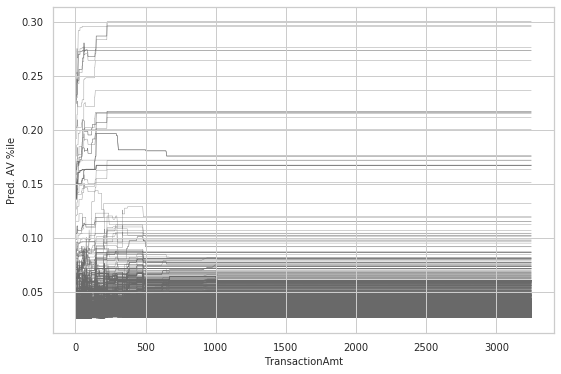

In [42]:
from matplotlib import rcParams

ice_df = ice(data=train_X_df[:5000], column='TransactionAmt', predict=lgbm.predict)

rcParams['figure.figsize'] = 8,6

ice_plot(ice_df , c='dimgray', linewidth=0.3)
plt.ylabel('Pred. AV %ile')
plt.xlabel('TransactionAmt');
plt.show()

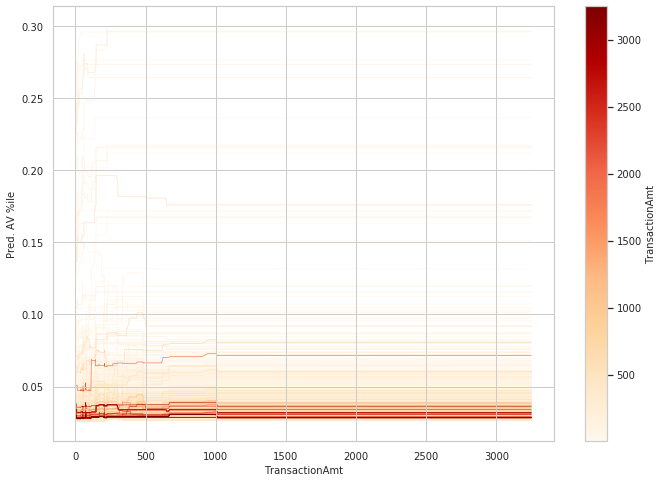

In [43]:
rcParams['figure.figsize'] = 10,8
cmap2 = plt.get_cmap('OrRd')
ice_plot(ice_df, linewidth=0.5, color_by='data_TransactionAmt', cmap=cmap2)

# https://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots/11558629#11558629

wt_vals = ice_df.columns.get_level_values('data_TransactionAmt').values
sm = plt.cm.ScalarMappable(cmap=cmap2, 
                           norm=plt.Normalize(vmin=wt_vals.min(), 
                                              vmax=wt_vals.max()))
# need to create fake array for the scalar mappable or else we get an error
sm._A = []
plt.colorbar(sm, label='TransactionAmt')
plt.ylabel('Pred. AV %ile')
plt.xlabel('TransactionAmt');
plt.show()

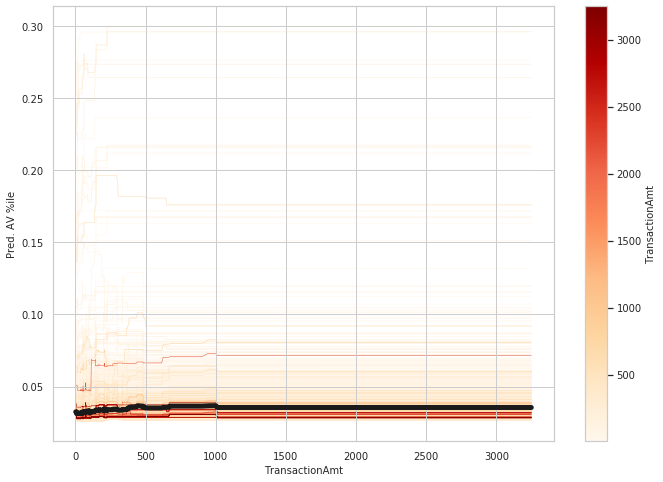

In [44]:
rcParams['figure.figsize'] = 10,8
ice_plot(ice_df, linewidth=.5, color_by='data_TransactionAmt', cmap=cmap2, plot_pdp=True, 
         pdp_kwargs={'c': 'k', 'linewidth': 5})
plt.colorbar(sm, label='TransactionAmt')
plt.ylabel('Pred. AV %ile')
plt.xlabel('TransactionAmt');
plt.show()

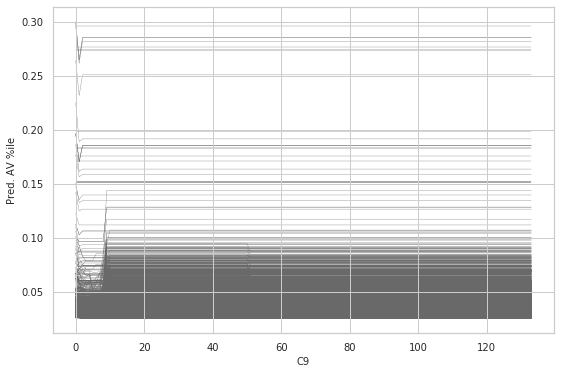

In [45]:
ice_df = ice(data=train_X_df[:5000], column='C9', predict=lgbm.predict)

rcParams['figure.figsize'] = 8,6

ice_plot(ice_df , c='dimgray', linewidth=0.3)
plt.ylabel('Pred. AV %ile')
plt.xlabel('C9');
plt.show()

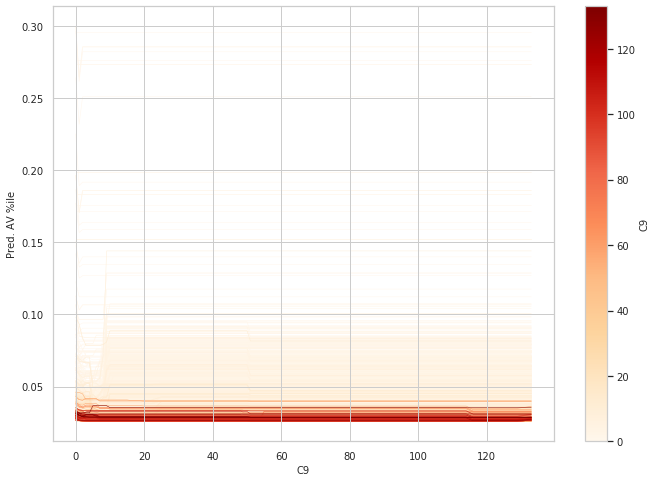

In [46]:
rcParams['figure.figsize'] = 10,8
cmap2 = plt.get_cmap('OrRd')
ice_plot(ice_df, linewidth=0.5, color_by='data_C9', cmap=cmap2)

# https://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots/11558629#11558629

wt_vals = ice_df.columns.get_level_values('data_C9').values
sm = plt.cm.ScalarMappable(cmap=cmap2, 
                           norm=plt.Normalize(vmin=wt_vals.min(), 
                                              vmax=wt_vals.max()))
# need to create fake array for the scalar mappable or else we get an error
sm._A = []
plt.colorbar(sm, label='C9')
plt.ylabel('Pred. AV %ile')
plt.xlabel('C9');
plt.show()

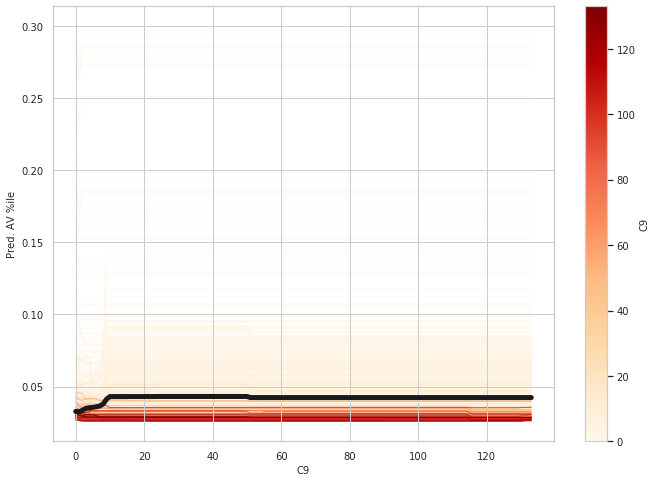

In [47]:
rcParams['figure.figsize'] = 10,8
ice_plot(ice_df, linewidth=.5, color_by='data_C9', cmap=cmap2, plot_pdp=True, 
         pdp_kwargs={'c': 'k', 'linewidth': 5})
plt.colorbar(sm, label='C9')
plt.ylabel('Pred. AV %ile')
plt.xlabel('C9');
plt.show()

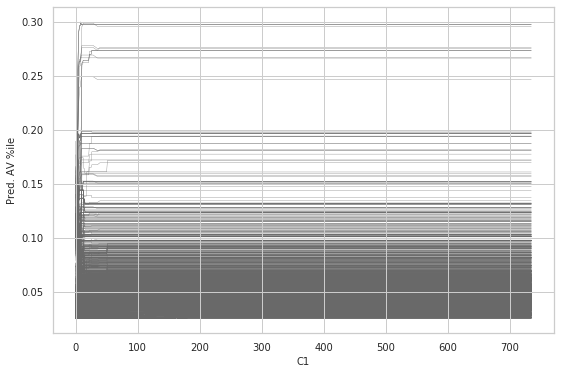

In [48]:
ice_df = ice(data=train_X_df[:5000], column='C1', predict=lgbm.predict)

rcParams['figure.figsize'] = 8,6

ice_plot(ice_df , c='dimgray', linewidth=0.3)
plt.ylabel('Pred. AV %ile')
plt.xlabel('C1');
plt.show()

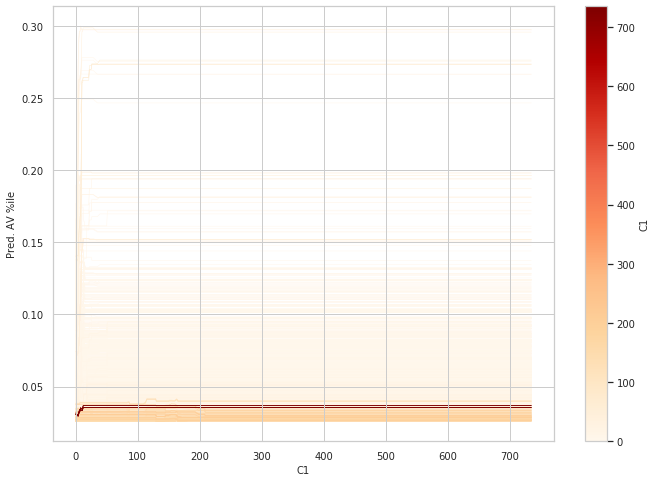

In [49]:
rcParams['figure.figsize'] = 10,8
cmap2 = plt.get_cmap('OrRd')
ice_plot(ice_df, linewidth=0.5, color_by='data_C1', cmap=cmap2)

# https://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots/11558629#11558629

wt_vals = ice_df.columns.get_level_values('data_C1').values
sm = plt.cm.ScalarMappable(cmap=cmap2, 
                           norm=plt.Normalize(vmin=wt_vals.min(), 
                                              vmax=wt_vals.max()))
# need to create fake array for the scalar mappable or else we get an error
sm._A = []
plt.colorbar(sm, label='C1')
plt.ylabel('Pred. AV %ile')
plt.xlabel('C1');
plt.show()

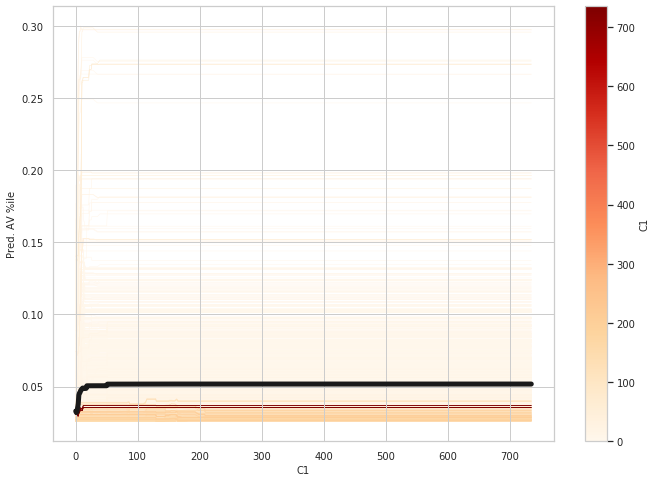

In [50]:
rcParams['figure.figsize'] = 10,8
ice_plot(ice_df, linewidth=.5, color_by='data_C1', cmap=cmap2, plot_pdp=True, 
         pdp_kwargs={'c': 'k', 'linewidth': 5})
plt.colorbar(sm, label='C1')
plt.ylabel('Pred. AV %ile')
plt.xlabel('C1');
plt.show()

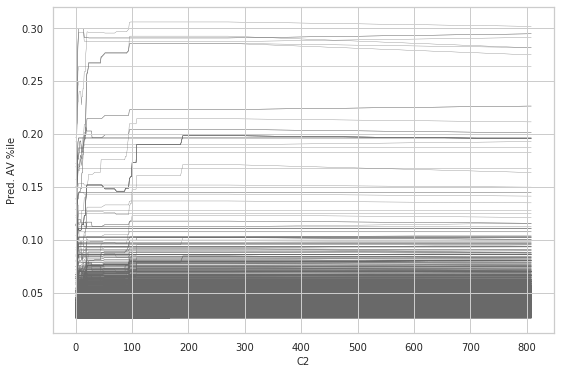

In [51]:
ice_df = ice(data=train_X_df[:5000], column='C2', predict=lgbm.predict)

rcParams['figure.figsize'] = 8,6

ice_plot(ice_df , c='dimgray', linewidth=0.3)
plt.ylabel('Pred. AV %ile')
plt.xlabel('C2');
plt.show()

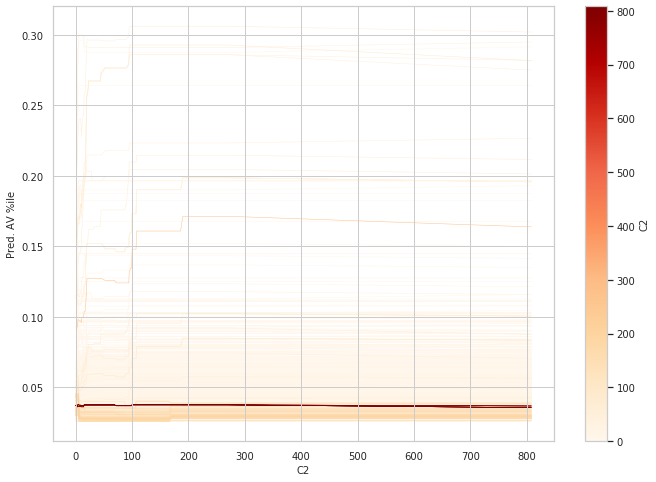

In [52]:
rcParams['figure.figsize'] = 10,8
cmap2 = plt.get_cmap('OrRd')
ice_plot(ice_df, linewidth=0.5, color_by='data_C2', cmap=cmap2)

wt_vals = ice_df.columns.get_level_values('data_C2').values
sm = plt.cm.ScalarMappable(cmap=cmap2, 
                           norm=plt.Normalize(vmin=wt_vals.min(), 
                                              vmax=wt_vals.max()))
# need to create fake array for the scalar mappable or else we get an error
sm._A = []

plt.colorbar(sm, label='C2')
plt.ylabel('Pred. AV %ile')
plt.xlabel('C2');
plt.show()

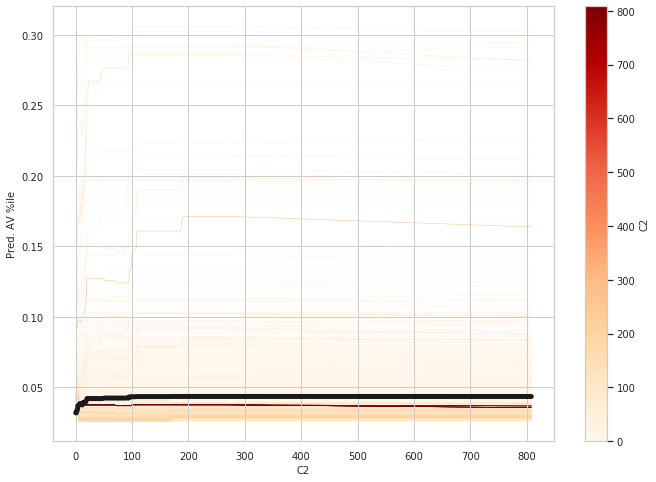

In [53]:
rcParams['figure.figsize'] = 10,8
ice_plot(ice_df, linewidth=.5, color_by='data_C2', cmap=cmap2, plot_pdp=True, pdp_kwargs={'c': 'k', 'linewidth': 5})

plt.colorbar(sm, label='C2')
plt.ylabel('Pred. AV %ile')
plt.xlabel('C2');
plt.show()

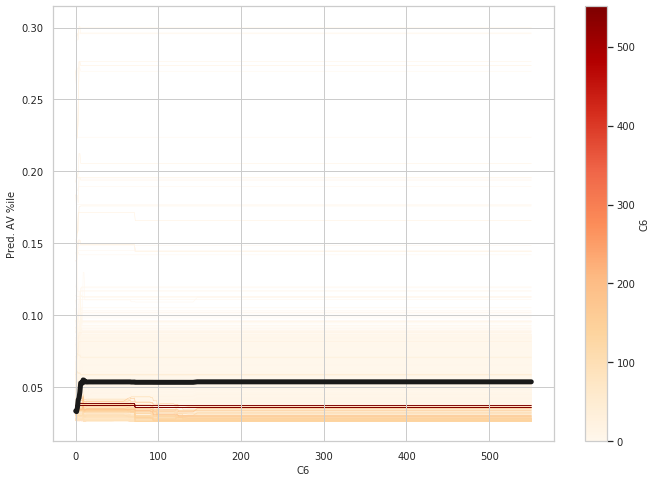

In [54]:
ice_df = ice(data=train_X_df[:5000], column='C6', predict=lgbm.predict)

cmap2 = plt.get_cmap('OrRd')

rcParams['figure.figsize'] = 10,8
ice_plot(ice_df, linewidth=.5, color_by='data_C6', cmap=cmap2, plot_pdp=True, pdp_kwargs={'c': 'k', 'linewidth': 5})

wt_vals = ice_df.columns.get_level_values('data_C6').values
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin=wt_vals.min(), vmax=wt_vals.max()))
sm._A = []

plt.colorbar(sm, label='C6')
plt.ylabel('Pred. AV %ile')
plt.xlabel('C6');
plt.show()

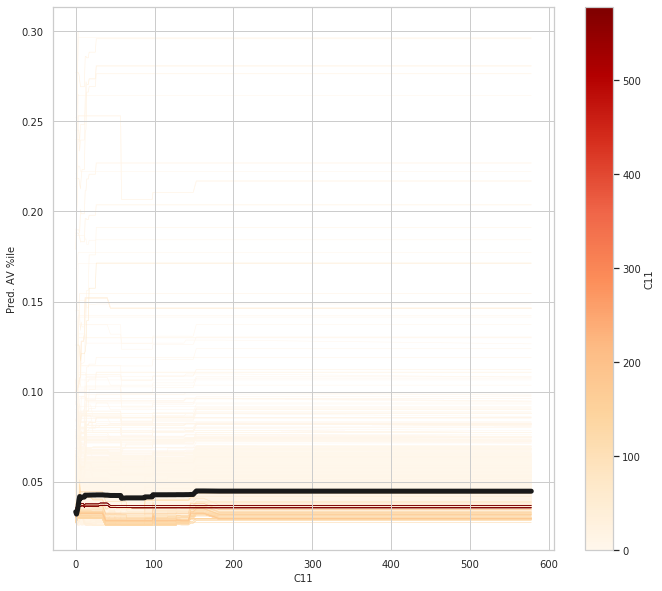

In [56]:
ice_df = ice(data=train_X_df[:5000], column='C11', predict=lgbm.predict)

cmap2 = plt.get_cmap('OrRd')

rcParams['figure.figsize'] = 10,8
ice_plot(ice_df, linewidth=.5, color_by='data_C11', cmap=cmap2, plot_pdp=True, pdp_kwargs={'c': 'k', 'linewidth': 5})

wt_vals = ice_df.columns.get_level_values('data_C11').values
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin=wt_vals.min(), vmax=wt_vals.max()))
sm._A = []

plt.colorbar(sm, label='C11')
plt.ylabel('Pred. AV %ile')
plt.xlabel('C11');
plt.show()

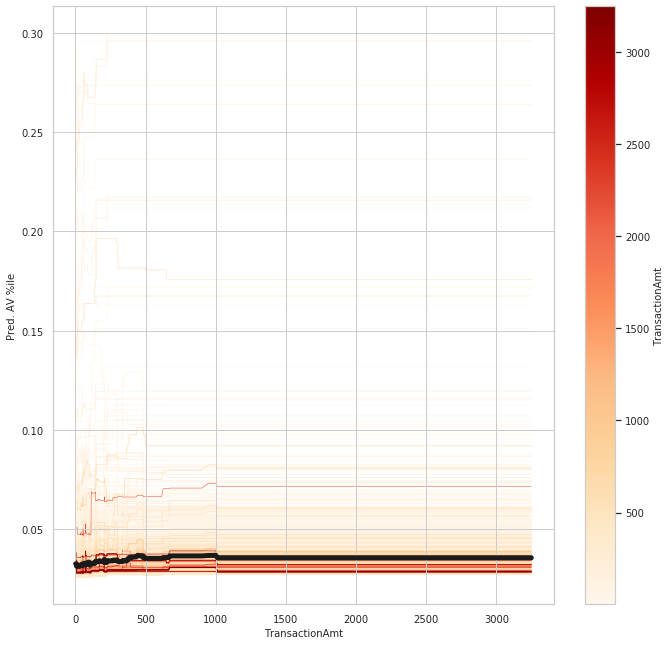

In [62]:
ice_df = ice(data=train_X_df[:5000], column='TransactionAmt', predict=lgbm.predict)

cmap2 = plt.get_cmap('OrRd')

rcParams['figure.figsize'] = 10,11
ice_plot(ice_df, linewidth=.5, color_by='data_TransactionAmt', cmap=cmap2, plot_pdp=True, pdp_kwargs={'c': 'k', 'linewidth': 5})

wt_vals = ice_df.columns.get_level_values('data_TransactionAmt').values
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin=wt_vals.min(), vmax=wt_vals.max()))
sm._A = []

plt.colorbar(sm, label='TransactionAmt')
plt.ylabel('Pred. AV %ile')
plt.xlabel('TransactionAmt');
plt.show()